In [12]:
import torch
import torchaudio
import noisereduce
import matplotlib.pyplot as plt
import numpy as np
import librosa
from math import ceil
from pprint import pprint
from torch import Tensor
from torch.utils.data import DataLoader
import pandas as pd

SPECTROGRAM_PARAMS = dict(
    sample_rate=32_000,
    hop_length=640,
    n_fft=800,
    n_mels=128,
    fmin=20,
    fmax=16_000,
    win_length=512
)
PCEN_PARAS = dict(
    time_constant=0.06,
    eps=1e-6,
    gain=0.8,
    power=0.25,
    bias=10,
)


@torch.no_grad()
def create_spectrogram(
    fname: str,
    reduce_noise: bool = False,
    frame_size: int = 5,
    frame_step: int = 2,
    spec_params: dict = SPECTROGRAM_PARAMS,
) -> list:
    waveform, sample_rate = librosa.core.load(fname, sr=spec_params["sample_rate"], mono=True)
    if reduce_noise:
        waveform = noisereduce.reduce_noise(
            y=waveform,
            sr=sample_rate,
            time_constant_s=float(5),
            time_mask_smooth_ms=250,
            n_fft=spec_params["n_fft"],
            use_tqdm=False,
            n_jobs=2,
        )

    step = int(frame_step * sample_rate)
    size = int(frame_size * sample_rate)
    count = ceil((len(waveform) - size) / float(step))
    frames = []
    for i in range(max(1, count)):
        begin = i * step
        frame = waveform[begin:begin + size]
        if len(frame) < size:
            if i == 0:
                rep = round(float(size) / len(frame))
                frame = frame.repeat(int(rep))
            elif len(frame) < (size * 0.33):
                continue
            else:
                frame = waveform[-size:]
        frames.append(frame)

    spectrograms = []
    for frm in frames:
        sg = librosa.feature.melspectrogram(
            y=frm,
            sr=sample_rate,
            n_fft=spec_params["n_fft"],
            win_length=spec_params["win_length"],
            hop_length=spec_params["hop_length"],
            n_mels=spec_params["n_mels"],
            fmin=spec_params["fmin"],
            fmax=spec_params["fmax"],
            power=1,
        )
#         sg = librosa.pcen(sg, sr=sample_rate, hop_length=spec_params["hop_length"], **PCEN_PARAS)
        sg = librosa.amplitude_to_db(sg, ref=np.max)
        spectrograms.append(np.nan_to_num(sg))
    return spectrograms

In [13]:
df = pd.read_csv("../../data/2024/train_metadata.csv")
df.head()

,primary_label,secondary_labels,type,latitude,longitude,scientific_name,common_name,author,license,rating,url,filename
0,asbfly,[],['call'],39.2297,118.1987,Muscicapa dauurica,Asian Brown Flycatcher,Matt Slaymaker,Creative Commons Attribution-NonCommercial-Sha...,5.0,https://www.xeno-canto.org/134896,asbfly/XC134896.ogg
1,asbfly,[],['song'],51.4030,104.6401,Muscicapa dauurica,Asian Brown Flycatcher,Magnus Hellström,Creative Commons Attribution-NonCommercial-Sha...,2.5,https://www.xeno-canto.org/164848,asbfly/XC164848.ogg
2,asbfly,[],['song'],36.3319,127.3555,Muscicapa dauurica,Asian Brown Flycatcher,Stuart Fisher,Creative Commons Attribution-NonCommercial-Sha...,2.5,https://www.xeno-canto.org/175797,asbfly/XC175797.ogg
3,asbfly,[],['call'],21.1697,70.6005,Muscicapa dauurica,Asian Brown Flycatcher,vir joshi,Creative Commons Attribution-NonCommercial-Sha...,4.0,https://www.xeno-canto.org/207738,asbfly/XC207738.ogg
4,asbfly,[],['call'],15.5442,73.7733,Muscicapa dauurica,Asian Brown Flycatcher,Albert Lastukhin & Sergei Karpeev,Creative Commons Attribution-NonCommercial-Sha...,4.0,https://www.xeno-canto.org/209218,asbfly/XC209218.ogg


In [14]:
from IPython.display import Audio
train_path = '../../data/2024/train_audio/'
data, rate = librosa.load(train_path + df.filename[13], sr = None)
display(Audio(data[0:rate*5], rate=rate))

In [16]:
waveform = noisereduce.reduce_noise(
    y=data,
    sr=rate,
    time_constant_s=float(5),
    time_mask_smooth_ms=250,
    n_fft=SPECTROGRAM_PARAMS["n_fft"],
    use_tqdm=False,
    n_jobs=2,
)

In [17]:
display(Audio(waveform[0:rate*5], rate=rate))

In [18]:
x = create_spectrogram(train_path + df.filename[13])
len(x)

17

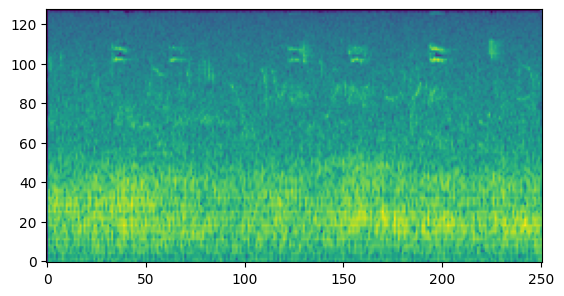

In [21]:
x = create_spectrogram(train_path + df.filename[13])
plt.imshow(x[0], origin='lower')

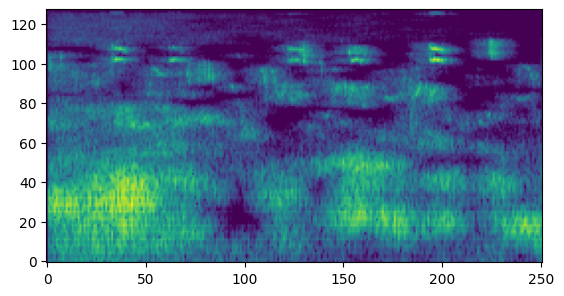

In [22]:
x = create_spectrogram(train_path + df.filename[13], reduce_noise = True)
plt.imshow(x[0], origin='lower')

In [24]:
x[0].shape

(128, 251)

# Export and save

In [23]:
from tqdm.auto import tqdm
from functools import partial
from joblib import Parallel, delayed

In [33]:
def convert_and_export(
    fn: str, path_in: str, path_out: str,
    reduce_noise: bool = False,
    frame_size: int = 5, frame_step: int = 2,
):
    path_audio = os.path.join(path_in, fn)
    try:
        sgs = create_spectrogram(
            path_audio,
            reduce_noise=reduce_noise,
            frame_size=frame_size,
            frame_step=frame_step,
        )
    except Exception as ex:
        print(f"Failed conversion for audio: {path_audio}")
        return
    if not sgs:
        print(f"Too short audio for: {path_audio}")
        return
    # see: https://www.kaggle.com/c/birdclef-2022/discussion/308861
    # this is adjustment for window 5s and step 2s
    nb = ceil((10 - frame_size) / frame_step) + 1
    if len(sgs) > 2 * nb:
        sgs = sgs[:nb] + sgs[-nb:]
#     path_npz = os.path.join(path_out, fn + '.npz')
#     os.makedirs(os.path.dirname(path_npz), exist_ok=True)
    # np.savez_compressed(path_npz, np.array(sgs, dtype=np.float16))
    for i, sg in enumerate(sgs):
        path_img = os.path.join(path_out, fn + f".{i:03}" + '.npy')
        os.makedirs('/'.join(path_img.split('/')[:-1]), exist_ok = True)
        try:
            # plt.imsave(path_img, sg, vmin=-70, vmax=20)
            np.save(path_img, sg)
            #             sg = (sg + 80) / 80.0
#             sg = np.clip(sg, a_min=0, a_max=1) * 255
#             img = Image.fromarray(sg.astype(np.uint8))
#             img.resize((256,256)).save(path_img)
        except Exception as ex:
            print(f"Failed exporting for image: {path_img}")
            continue

In [34]:
# k = '../../preprocessed_data/simple_5sec_spectrogram/asikoe2/XC412822.ogg.006.npy'
# '/'.join(k.split('/')[:-1])

In [35]:
import os
_convert_and_export = partial(
    convert_and_export,
    path_in=os.path.join('../../data/2024/', "train_audio"),
    path_out="../../preprocessed_data/simple_5sec_spectrogram",
)

_= Parallel(n_jobs=3)(delayed(_convert_and_export)(fn) for fn in tqdm(df["filename"]))



  0%|                                                                                                               | 0/24459 [00:00<?, ?it/s]

  0%|                                                                                                     | 6/24459 [00:02<3:23:03,  2.01it/s]

  0%|                                                                                                     | 9/24459 [00:03<2:08:01,  3.18it/s]

  0%|                                                                                                    | 12/24459 [00:03<1:32:12,  4.42it/s]

  0%|                                                                                                    | 15/24459 [00:03<1:12:12,  5.64it/s]

  0%|                                                                                                    | 18/24459 [00:03<1:01:34,  6.62it/s]

  0%|                                                                                                    | 21/24459 [00:04<1:04:26,  6

  2%|█▋                                                                                                   | 405/24459 [00:32<30:36, 13.10it/s]

  2%|█▋                                                                                                   | 411/24459 [00:33<25:29, 15.72it/s]

  2%|█▋                                                                                                   | 417/24459 [00:33<26:52, 14.91it/s]

  2%|█▋                                                                                                   | 423/24459 [00:33<25:14, 15.87it/s]

  2%|█▊                                                                                                   | 429/24459 [00:34<28:23, 14.11it/s]

  2%|█▊                                                                                                   | 435/24459 [00:35<36:27, 10.98it/s]

  2%|█▊                                                                                                   | 441/24459 [00:35<31:49, 12.5

  4%|███▋                                                                                                 | 897/24459 [01:15<24:25, 16.08it/s]

  4%|███▋                                                                                                 | 903/24459 [01:15<23:55, 16.41it/s]

  4%|███▋                                                                                                 | 906/24459 [01:15<27:19, 14.37it/s]

  4%|███▊                                                                                                 | 909/24459 [01:16<26:57, 14.56it/s]

  4%|███▊                                                                                                 | 912/24459 [01:16<23:17, 16.85it/s]

  4%|███▊                                                                                                 | 918/24459 [01:16<19:54, 19.70it/s]

  4%|███▊                                                                                                 | 927/24459 [01:16<17:01, 23.0

  6%|██████▏                                                                                             | 1515/24459 [01:58<34:18, 11.15it/s]

  6%|██████▏                                                                                             | 1521/24459 [01:58<33:12, 11.51it/s]

  6%|██████▏                                                                                             | 1527/24459 [01:59<30:38, 12.47it/s]

  6%|██████▎                                                                                             | 1533/24459 [01:59<34:46, 10.99it/s]

  6%|██████▎                                                                                             | 1539/24459 [02:00<39:23,  9.70it/s]

  6%|██████▎                                                                                             | 1545/24459 [02:00<31:36, 12.08it/s]

  6%|██████▎                                                                                             | 1551/24459 [02:01<32:39, 11.6

  9%|████████▌                                                                                         | 2124/24459 [02:48<1:12:39,  5.12it/s]

  9%|████████▋                                                                                           | 2127/24459 [02:48<54:53,  6.78it/s]

  9%|████████▋                                                                                           | 2130/24459 [02:48<53:07,  7.01it/s]

  9%|████████▋                                                                                           | 2133/24459 [02:49<46:20,  8.03it/s]

  9%|████████▋                                                                                           | 2136/24459 [02:49<50:30,  7.37it/s]

  9%|████████▌                                                                                         | 2139/24459 [02:50<1:02:39,  5.94it/s]

  9%|████████▌                                                                                         | 2142/24459 [02:52<2:03:18,  3.0

 10%|██████████                                                                                          | 2475/24459 [03:16<18:24, 19.91it/s]

 10%|██████████▏                                                                                         | 2478/24459 [03:16<25:04, 14.61it/s]

 10%|██████████▏                                                                                         | 2481/24459 [03:16<25:04, 14.60it/s]

 10%|██████████▏                                                                                         | 2484/24459 [03:17<25:44, 14.22it/s]

 10%|██████████▏                                                                                         | 2490/24459 [03:17<22:58, 15.93it/s]

 10%|██████████▏                                                                                         | 2493/24459 [03:17<22:47, 16.06it/s]

 10%|██████████▏                                                                                         | 2496/24459 [03:17<24:16, 15.0

 12%|███████████▉                                                                                        | 2919/24459 [03:52<15:47, 22.73it/s]

 12%|███████████▉                                                                                        | 2925/24459 [03:52<19:56, 18.00it/s]

 12%|███████████▉                                                                                        | 2931/24459 [03:53<24:02, 14.92it/s]

 12%|████████████                                                                                        | 2937/24459 [03:53<23:03, 15.56it/s]

 12%|████████████                                                                                        | 2943/24459 [03:53<23:56, 14.98it/s]

 12%|████████████                                                                                        | 2949/24459 [03:54<20:00, 17.91it/s]

 12%|████████████                                                                                        | 2955/24459 [03:54<27:32, 13.0

 14%|█████████████▉                                                                                      | 3399/24459 [04:57<47:32,  7.38it/s]

 14%|█████████████▉                                                                                      | 3402/24459 [04:58<47:13,  7.43it/s]

 14%|█████████████▋                                                                                    | 3405/24459 [04:59<1:07:15,  5.22it/s]

 14%|█████████████▋                                                                                    | 3408/24459 [04:59<1:05:04,  5.39it/s]

 14%|█████████████▋                                                                                    | 3411/24459 [05:00<1:04:10,  5.47it/s]

 14%|█████████████▋                                                                                    | 3414/24459 [05:00<1:10:47,  4.95it/s]

 14%|█████████████▋                                                                                    | 3417/24459 [05:01<1:01:35,  5.6

 15%|██████████████▉                                                                                   | 3723/24459 [07:18<3:23:31,  1.70it/s]

 15%|██████████████▉                                                                                   | 3726/24459 [07:18<2:29:33,  2.31it/s]

 15%|██████████████▉                                                                                   | 3729/24459 [07:19<2:13:15,  2.59it/s]

 15%|██████████████▉                                                                                   | 3732/24459 [07:19<1:37:44,  3.53it/s]

 15%|██████████████▉                                                                                   | 3735/24459 [07:19<1:26:21,  4.00it/s]

 15%|██████████████▉                                                                                   | 3738/24459 [07:20<1:14:46,  4.62it/s]

 15%|██████████████▉                                                                                   | 3741/24459 [07:20<1:18:40,  4.3

 17%|████████████████▋                                                                                   | 4068/24459 [07:53<14:53, 22.82it/s]

 17%|████████████████▋                                                                                   | 4074/24459 [07:53<13:43, 24.75it/s]

 17%|████████████████▋                                                                                   | 4077/24459 [07:54<15:37, 21.74it/s]

 17%|████████████████▋                                                                                   | 4080/24459 [07:54<18:36, 18.25it/s]

 17%|████████████████▋                                                                                   | 4083/24459 [07:54<22:35, 15.03it/s]

 17%|████████████████▋                                                                                   | 4086/24459 [07:54<20:12, 16.80it/s]

 17%|████████████████▋                                                                                   | 4092/24459 [07:55<17:43, 19.1

 18%|██████████████████▍                                                                                 | 4518/24459 [08:33<44:20,  7.49it/s]

 18%|██████████████████▍                                                                                 | 4521/24459 [08:33<39:25,  8.43it/s]

 18%|██████████████████▍                                                                                 | 4524/24459 [08:33<36:27,  9.11it/s]

 19%|██████████████████▌                                                                                 | 4530/24459 [08:34<28:21, 11.71it/s]

 19%|██████████████████▌                                                                                 | 4536/24459 [08:34<21:22, 15.53it/s]

 19%|██████████████████▌                                                                                 | 4542/24459 [08:34<25:08, 13.20it/s]

 19%|██████████████████▌                                                                                 | 4548/24459 [08:35<27:51, 11.9

 21%|████████████████████▋                                                                               | 5070/24459 [09:09<22:08, 14.59it/s]

 21%|████████████████████▊                                                                               | 5076/24459 [09:09<21:28, 15.04it/s]

 21%|████████████████████▊                                                                               | 5082/24459 [09:10<18:33, 17.40it/s]

 21%|████████████████████▊                                                                               | 5088/24459 [09:10<18:01, 17.90it/s]

 21%|████████████████████▊                                                                               | 5094/24459 [09:10<19:46, 16.33it/s]

 21%|████████████████████▊                                                                               | 5100/24459 [09:11<20:37, 15.64it/s]

 21%|████████████████████▉                                                                               | 5106/24459 [09:11<21:38, 14.9

 23%|███████████████████████▍                                                                            | 5736/24459 [09:53<35:30,  8.79it/s]

 23%|███████████████████████▍                                                                            | 5742/24459 [09:54<37:41,  8.28it/s]

 24%|███████████████████████▌                                                                            | 5748/24459 [09:55<42:51,  7.28it/s]

 24%|███████████████████████▌                                                                            | 5754/24459 [09:56<37:38,  8.28it/s]

 24%|███████████████████████▌                                                                            | 5760/24459 [09:56<35:21,  8.81it/s]

 24%|███████████████████████▌                                                                            | 5766/24459 [09:57<32:05,  9.71it/s]

 24%|███████████████████████▌                                                                            | 5772/24459 [09:57<24:59, 12.4

 26%|██████████████████████████▏                                                                         | 6414/24459 [10:24<11:45, 25.58it/s]

 26%|██████████████████████████▏                                                                         | 6420/24459 [10:24<18:36, 16.16it/s]

 26%|██████████████████████████▎                                                                         | 6426/24459 [10:25<24:05, 12.48it/s]

 26%|██████████████████████████▎                                                                         | 6432/24459 [10:25<20:56, 14.34it/s]

 26%|██████████████████████████▎                                                                         | 6438/24459 [10:26<21:09, 14.20it/s]

 26%|██████████████████████████▎                                                                         | 6444/24459 [10:26<17:07, 17.53it/s]

 26%|██████████████████████████▎                                                                         | 6450/24459 [10:26<16:26, 18.2

 28%|████████████████████████████▍                                                                       | 6963/24459 [11:46<39:30,  7.38it/s]

 28%|████████████████████████████▍                                                                       | 6966/24459 [11:46<35:00,  8.33it/s]

 29%|████████████████████████████▌                                                                       | 6972/24459 [11:46<33:53,  8.60it/s]

 29%|████████████████████████████▌                                                                       | 6975/24459 [11:47<30:34,  9.53it/s]

 29%|████████████████████████████▌                                                                       | 6978/24459 [11:47<33:54,  8.59it/s]

 29%|████████████████████████████▌                                                                       | 6981/24459 [11:48<38:27,  7.58it/s]

 29%|████████████████████████████▌                                                                       | 6984/24459 [11:48<32:12,  9.0

 30%|█████████████████████████████▉                                                                      | 7320/24459 [12:22<23:06, 12.36it/s]

 30%|█████████████████████████████▉                                                                      | 7323/24459 [12:22<20:19, 14.05it/s]

 30%|█████████████████████████████▉                                                                      | 7326/24459 [12:22<19:01, 15.01it/s]

 30%|█████████████████████████████▉                                                                      | 7329/24459 [12:22<17:10, 16.62it/s]

 30%|█████████████████████████████▉                                                                      | 7335/24459 [12:23<17:59, 15.86it/s]

 30%|██████████████████████████████                                                                      | 7338/24459 [12:23<16:04, 17.76it/s]

 30%|██████████████████████████████                                                                      | 7341/24459 [12:23<15:34, 18.3

 33%|█████████████████████████████████▍                                                                  | 8193/24459 [13:11<18:05, 14.98it/s]

 34%|█████████████████████████████████▌                                                                  | 8196/24459 [13:11<19:35, 13.83it/s]

 34%|█████████████████████████████████▌                                                                  | 8199/24459 [13:11<19:25, 13.95it/s]

 34%|█████████████████████████████████▌                                                                  | 8205/24459 [13:12<14:04, 19.24it/s]

 34%|█████████████████████████████████▌                                                                  | 8208/24459 [13:12<15:51, 17.07it/s]

 34%|█████████████████████████████████▌                                                                  | 8211/24459 [13:12<15:32, 17.43it/s]

 34%|█████████████████████████████████▌                                                                  | 8214/24459 [13:12<15:03, 17.9

 35%|███████████████████████████████████▎                                                                | 8628/24459 [13:42<16:06, 16.39it/s]

 35%|███████████████████████████████████▎                                                                | 8634/24459 [13:43<15:57, 16.52it/s]

 35%|███████████████████████████████████▎                                                                | 8640/24459 [13:43<14:42, 17.92it/s]

 35%|███████████████████████████████████▎                                                                | 8646/24459 [13:43<15:15, 17.26it/s]

 35%|███████████████████████████████████▎                                                                | 8652/24459 [13:44<13:49, 19.06it/s]

 35%|███████████████████████████████████▍                                                                | 8658/24459 [13:44<11:30, 22.89it/s]

 35%|███████████████████████████████████▍                                                                | 8664/24459 [13:44<10:10, 25.8

 38%|█████████████████████████████████████▋                                                              | 9222/24459 [14:27<20:50, 12.19it/s]

 38%|█████████████████████████████████████▋                                                              | 9225/24459 [14:27<17:36, 14.42it/s]

 38%|█████████████████████████████████████▋                                                              | 9228/24459 [14:27<19:15, 13.18it/s]

 38%|█████████████████████████████████████▋                                                              | 9231/24459 [14:28<27:35,  9.20it/s]

 38%|█████████████████████████████████████▊                                                              | 9234/24459 [14:28<23:36, 10.74it/s]

 38%|█████████████████████████████████████▊                                                              | 9243/24459 [14:28<12:19, 20.57it/s]

 38%|█████████████████████████████████████▊                                                              | 9247/24459 [14:28<14:06, 17.9

 39%|███████████████████████████████████████▍                                                            | 9645/24459 [15:01<17:50, 13.84it/s]

 39%|███████████████████████████████████████▍                                                            | 9648/24459 [15:01<17:33, 14.06it/s]

 39%|███████████████████████████████████████▍                                                            | 9654/24459 [15:01<12:40, 19.47it/s]

 39%|███████████████████████████████████████▍                                                            | 9657/24459 [15:02<15:57, 15.46it/s]

 40%|███████████████████████████████████████▌                                                            | 9663/24459 [15:02<17:32, 14.05it/s]

 40%|███████████████████████████████████████▌                                                            | 9666/24459 [15:02<18:36, 13.25it/s]

 40%|███████████████████████████████████████▌                                                            | 9669/24459 [15:03<18:08, 13.5

 42%|█████████████████████████████████████████▌                                                         | 10281/24459 [15:34<09:13, 25.61it/s]

 42%|█████████████████████████████████████████▋                                                         | 10287/24459 [15:34<08:09, 28.95it/s]

 42%|█████████████████████████████████████████▋                                                         | 10293/24459 [15:35<11:54, 19.82it/s]

 42%|█████████████████████████████████████████▋                                                         | 10299/24459 [15:35<10:43, 22.01it/s]

 42%|█████████████████████████████████████████▋                                                         | 10305/24459 [15:35<10:54, 21.62it/s]

 42%|█████████████████████████████████████████▋                                                         | 10311/24459 [15:35<09:46, 24.13it/s]

 42%|█████████████████████████████████████████▊                                                         | 10317/24459 [15:36<10:13, 23.0

 44%|███████████████████████████████████████████▊                                                       | 10839/24459 [16:15<12:35, 18.03it/s]

 44%|███████████████████████████████████████████▉                                                       | 10845/24459 [16:15<10:39, 21.29it/s]

 44%|███████████████████████████████████████████▉                                                       | 10851/24459 [16:15<10:17, 22.03it/s]

 44%|███████████████████████████████████████████▉                                                       | 10857/24459 [16:16<08:58, 25.24it/s]

 44%|███████████████████████████████████████████▉                                                       | 10863/24459 [16:16<09:41, 23.39it/s]

 44%|███████████████████████████████████████████▉                                                       | 10869/24459 [16:16<12:57, 17.49it/s]

 44%|████████████████████████████████████████████                                                       | 10875/24459 [16:18<21:17, 10.6

 47%|██████████████████████████████████████████████▉                                                    | 11601/24459 [16:57<20:22, 10.52it/s]

 47%|██████████████████████████████████████████████▉                                                    | 11604/24459 [16:57<19:26, 11.02it/s]

 47%|██████████████████████████████████████████████▉                                                    | 11607/24459 [16:58<18:26, 11.61it/s]

 47%|██████████████████████████████████████████████▉                                                    | 11610/24459 [16:58<16:18, 13.14it/s]

 47%|███████████████████████████████████████████████                                                    | 11613/24459 [16:58<15:12, 14.07it/s]

 48%|███████████████████████████████████████████████                                                    | 11619/24459 [16:58<12:49, 16.69it/s]

 48%|███████████████████████████████████████████████                                                    | 11622/24459 [16:58<11:59, 17.8

 49%|████████████████████████████████████████████████▍                                                  | 11955/24459 [17:31<26:04,  7.99it/s]

 49%|████████████████████████████████████████████████▍                                                  | 11958/24459 [17:31<25:00,  8.33it/s]

 49%|████████████████████████████████████████████████▍                                                  | 11961/24459 [17:31<24:30,  8.50it/s]

 49%|████████████████████████████████████████████████▍                                                  | 11964/24459 [17:32<35:38,  5.84it/s]

 49%|████████████████████████████████████████████████▍                                                  | 11967/24459 [17:33<38:40,  5.38it/s]

 49%|████████████████████████████████████████████████▍                                                  | 11970/24459 [17:33<33:01,  6.30it/s]

 49%|████████████████████████████████████████████████▍                                                  | 11973/24459 [17:33<28:09,  7.3

 51%|██████████████████████████████████████████████████▏                                                | 12396/24459 [18:15<09:31, 21.12it/s]

 51%|██████████████████████████████████████████████████▏                                                | 12408/24459 [18:15<07:32, 26.63it/s]

 51%|██████████████████████████████████████████████████▏                                                | 12414/24459 [18:15<07:57, 25.22it/s]

 51%|██████████████████████████████████████████████████▎                                                | 12420/24459 [18:15<06:45, 29.65it/s]

 51%|██████████████████████████████████████████████████▎                                                | 12426/24459 [18:16<08:33, 23.42it/s]

 51%|██████████████████████████████████████████████████▎                                                | 12432/24459 [18:16<08:42, 23.01it/s]

 51%|██████████████████████████████████████████████████▎                                                | 12438/24459 [18:16<07:31, 26.6

 53%|████████████████████████████████████████████████████▊                                              | 13050/24459 [19:00<11:12, 16.97it/s]

 53%|████████████████████████████████████████████████████▊                                              | 13056/24459 [19:01<13:11, 14.41it/s]

 53%|████████████████████████████████████████████████████▊                                              | 13062/24459 [19:01<10:51, 17.49it/s]

 53%|████████████████████████████████████████████████████▉                                              | 13068/24459 [19:01<10:17, 18.45it/s]

 53%|████████████████████████████████████████████████████▉                                              | 13074/24459 [19:02<09:30, 19.97it/s]

 53%|████████████████████████████████████████████████████▉                                              | 13080/24459 [19:02<07:56, 23.89it/s]

 54%|████████████████████████████████████████████████████▉                                              | 13086/24459 [19:02<07:01, 26.9

 56%|███████████████████████████████████████████████████████▌                                           | 13716/24459 [19:40<14:15, 12.55it/s]

 56%|███████████████████████████████████████████████████████▌                                           | 13722/24459 [19:41<14:18, 12.51it/s]

 56%|███████████████████████████████████████████████████████▌                                           | 13728/24459 [19:41<13:39, 13.09it/s]

 56%|███████████████████████████████████████████████████████▌                                           | 13734/24459 [19:42<14:53, 12.00it/s]

 56%|███████████████████████████████████████████████████████▌                                           | 13740/24459 [19:42<14:50, 12.03it/s]

 56%|███████████████████████████████████████████████████████▋                                           | 13746/24459 [19:43<13:54, 12.84it/s]

 56%|███████████████████████████████████████████████████████▋                                           | 13752/24459 [19:43<11:26, 15.5

 58%|█████████████████████████████████████████████████████████▋                                         | 14262/24459 [20:30<10:01, 16.95it/s]

 58%|█████████████████████████████████████████████████████████▋                                         | 14265/24459 [20:31<27:22,  6.21it/s]

 58%|█████████████████████████████████████████████████████████▊                                         | 14268/24459 [20:32<25:13,  6.73it/s]

 58%|█████████████████████████████████████████████████████████▊                                         | 14271/24459 [20:32<26:41,  6.36it/s]

 58%|█████████████████████████████████████████████████████████▊                                         | 14274/24459 [20:33<26:50,  6.33it/s]

 58%|█████████████████████████████████████████████████████████▊                                         | 14277/24459 [20:33<33:07,  5.12it/s]

 58%|█████████████████████████████████████████████████████████▊                                         | 14280/24459 [20:34<38:22,  4.4

 60%|███████████████████████████████████████████████████████████▎                                       | 14646/24459 [21:07<15:28, 10.57it/s]

 60%|███████████████████████████████████████████████████████████▎                                       | 14652/24459 [21:07<14:05, 11.60it/s]

 60%|███████████████████████████████████████████████████████████▎                                       | 14658/24459 [21:08<19:03,  8.57it/s]

 60%|███████████████████████████████████████████████████████████▎                                       | 14664/24459 [21:09<15:55, 10.25it/s]

 60%|███████████████████████████████████████████████████████████▍                                       | 14670/24459 [21:09<13:46, 11.84it/s]

 60%|███████████████████████████████████████████████████████████▍                                       | 14676/24459 [21:09<12:02, 13.53it/s]

 60%|███████████████████████████████████████████████████████████▍                                       | 14682/24459 [21:10<14:00, 11.6

 61%|████████████████████████████████████████████████████████████▉                                      | 15042/24459 [22:10<18:51,  8.32it/s]

 62%|████████████████████████████████████████████████████████████▉                                      | 15045/24459 [22:10<18:48,  8.34it/s]

 62%|████████████████████████████████████████████████████████████▉                                      | 15048/24459 [22:11<20:47,  7.54it/s]

 62%|████████████████████████████████████████████████████████████▉                                      | 15051/24459 [22:11<18:02,  8.69it/s]

 62%|████████████████████████████████████████████████████████████▉                                      | 15054/24459 [22:11<17:54,  8.75it/s]

 62%|████████████████████████████████████████████████████████████▉                                      | 15057/24459 [22:11<16:38,  9.41it/s]

 62%|████████████████████████████████████████████████████████████▉                                      | 15060/24459 [22:12<20:50,  7.5

 63%|██████████████████████████████████████████████████████████████▎                                    | 15405/24459 [22:49<08:12, 18.38it/s]

 63%|██████████████████████████████████████████████████████████████▍                                    | 15411/24459 [22:49<08:08, 18.50it/s]

 63%|██████████████████████████████████████████████████████████████▍                                    | 15417/24459 [22:50<10:56, 13.78it/s]

 63%|██████████████████████████████████████████████████████████████▍                                    | 15423/24459 [22:50<09:19, 16.14it/s]

 63%|██████████████████████████████████████████████████████████████▍                                    | 15429/24459 [22:50<10:22, 14.51it/s]

 63%|██████████████████████████████████████████████████████████████▍                                    | 15435/24459 [22:51<11:27, 13.12it/s]

 63%|██████████████████████████████████████████████████████████████▍                                    | 15441/24459 [22:52<13:33, 11.0

 66%|█████████████████████████████████████████████████████████████████▏                                 | 16095/24459 [23:29<09:05, 15.33it/s]

 66%|█████████████████████████████████████████████████████████████████▏                                 | 16101/24459 [23:29<07:57, 17.51it/s]

 66%|█████████████████████████████████████████████████████████████████▏                                 | 16107/24459 [23:29<07:28, 18.63it/s]

 66%|█████████████████████████████████████████████████████████████████▏                                 | 16113/24459 [23:30<09:04, 15.33it/s]

 66%|█████████████████████████████████████████████████████████████████▏                                 | 16119/24459 [23:30<10:08, 13.69it/s]

 66%|█████████████████████████████████████████████████████████████████▎                                 | 16125/24459 [23:30<08:01, 17.30it/s]

 66%|█████████████████████████████████████████████████████████████████▎                                 | 16131/24459 [23:31<09:44, 14.2

 68%|███████████████████████████████████████████████████████████████████▋                               | 16722/24459 [24:12<07:21, 17.53it/s]

 68%|███████████████████████████████████████████████████████████████████▋                               | 16728/24459 [24:13<06:29, 19.86it/s]

 68%|███████████████████████████████████████████████████████████████████▋                               | 16734/24459 [24:13<06:19, 20.34it/s]

 68%|███████████████████████████████████████████████████████████████████▊                               | 16740/24459 [24:13<05:37, 22.87it/s]

 68%|███████████████████████████████████████████████████████████████████▊                               | 16746/24459 [24:13<06:09, 20.85it/s]

 68%|███████████████████████████████████████████████████████████████████▊                               | 16752/24459 [24:14<06:30, 19.74it/s]

 69%|███████████████████████████████████████████████████████████████████▊                               | 16758/24459 [24:14<06:00, 21.3

 72%|███████████████████████████████████████████████████████████████████████▎                           | 17616/24459 [24:59<04:50, 23.58it/s]

 72%|███████████████████████████████████████████████████████████████████████▎                           | 17628/24459 [24:59<04:42, 24.22it/s]

 72%|███████████████████████████████████████████████████████████████████████▍                           | 17640/24459 [25:00<04:56, 22.99it/s]

 72%|███████████████████████████████████████████████████████████████████████▍                           | 17652/24459 [25:00<04:35, 24.72it/s]

 72%|███████████████████████████████████████████████████████████████████████▍                           | 17664/24459 [25:01<04:12, 26.92it/s]

 72%|███████████████████████████████████████████████████████████████████████▌                           | 17676/24459 [25:01<03:32, 31.94it/s]

 72%|███████████████████████████████████████████████████████████████████████▌                           | 17688/24459 [25:01<03:34, 31.6

 75%|██████████████████████████████████████████████████████████████████████████▌                        | 18414/24459 [25:50<07:16, 13.85it/s]

 75%|██████████████████████████████████████████████████████████████████████████▌                        | 18420/24459 [25:50<08:24, 11.96it/s]

 75%|██████████████████████████████████████████████████████████████████████████▌                        | 18426/24459 [25:51<06:50, 14.71it/s]

 75%|██████████████████████████████████████████████████████████████████████████▌                        | 18432/24459 [25:51<06:46, 14.82it/s]

 75%|██████████████████████████████████████████████████████████████████████████▋                        | 18438/24459 [25:52<08:05, 12.41it/s]

 75%|██████████████████████████████████████████████████████████████████████████▋                        | 18444/24459 [25:52<07:24, 13.54it/s]

 75%|██████████████████████████████████████████████████████████████████████████▋                        | 18450/24459 [25:52<06:42, 14.9

 79%|██████████████████████████████████████████████████████████████████████████████▌                    | 19398/24459 [26:46<05:06, 16.53it/s]

 79%|██████████████████████████████████████████████████████████████████████████████▌                    | 19410/24459 [26:47<05:07, 16.44it/s]

 79%|██████████████████████████████████████████████████████████████████████████████▌                    | 19422/24459 [26:48<04:59, 16.83it/s]

 79%|██████████████████████████████████████████████████████████████████████████████▋                    | 19434/24459 [26:49<05:05, 16.43it/s]

 80%|██████████████████████████████████████████████████████████████████████████████▋                    | 19446/24459 [26:49<05:03, 16.51it/s]

 80%|██████████████████████████████████████████████████████████████████████████████▊                    | 19458/24459 [26:50<05:00, 16.62it/s]

 80%|██████████████████████████████████████████████████████████████████████████████▊                    | 19470/24459 [26:51<04:29, 18.4

 82%|█████████████████████████████████████████████████████████████████████████████████▍                 | 20121/24459 [27:41<06:09, 11.75it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████▍                 | 20127/24459 [27:41<06:42, 10.75it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████▍                 | 20133/24459 [27:42<07:28,  9.65it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████▌                 | 20139/24459 [27:43<09:16,  7.76it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████▌                 | 20145/24459 [27:44<10:17,  6.99it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████▌                 | 20151/24459 [27:46<12:56,  5.55it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████▌                 | 20154/24459 [27:46<13:28,  5.3

 84%|███████████████████████████████████████████████████████████████████████████████████▍               | 20601/24459 [28:21<04:27, 14.42it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████▍               | 20604/24459 [28:22<04:03, 15.86it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████▍               | 20607/24459 [28:22<03:51, 16.61it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████▍               | 20613/24459 [28:22<03:04, 20.82it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████▍               | 20616/24459 [28:22<03:32, 18.04it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████▍               | 20619/24459 [28:22<03:37, 17.63it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████▍               | 20622/24459 [28:23<03:47, 16.8

 87%|█████████████████████████████████████████████████████████████████████████████████████▉             | 21234/24459 [29:06<03:56, 13.65it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████▉             | 21240/24459 [29:07<04:13, 12.69it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████▉             | 21246/24459 [29:07<04:01, 13.32it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████             | 21252/24459 [29:08<03:37, 14.75it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████             | 21258/24459 [29:08<03:22, 15.83it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████             | 21264/24459 [29:08<03:44, 14.24it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████             | 21270/24459 [29:09<03:23, 15.6

 90%|████████████████████████████████████████████████████████████████████████████████████████▌          | 21894/24459 [29:53<03:12, 13.31it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████▋          | 21900/24459 [29:53<02:52, 14.85it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████▋          | 21906/24459 [29:53<02:45, 15.44it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████▋          | 21912/24459 [29:54<02:50, 14.94it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████▋          | 21918/24459 [29:54<02:55, 14.51it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████▋          | 21924/24459 [29:54<02:31, 16.79it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████▊          | 21930/24459 [29:55<02:45, 15.2

 91%|██████████████████████████████████████████████████████████████████████████████████████████▍        | 22329/24459 [30:33<02:33, 13.85it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████▍        | 22332/24459 [30:33<02:20, 15.18it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████▍        | 22335/24459 [30:33<02:32, 13.91it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████▍        | 22338/24459 [30:33<02:32, 13.91it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████▍        | 22341/24459 [30:34<02:32, 13.87it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████▍        | 22344/24459 [30:34<03:25, 10.32it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████▍        | 22347/24459 [30:34<03:01, 11.6

 93%|████████████████████████████████████████████████████████████████████████████████████████████▏      | 22776/24459 [31:12<02:41, 10.44it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████▏      | 22779/24459 [31:12<02:35, 10.77it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████▏      | 22782/24459 [31:12<02:13, 12.54it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████▏      | 22785/24459 [31:13<02:34, 10.82it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████▏      | 22788/24459 [31:13<02:16, 12.22it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████▏      | 22791/24459 [31:13<02:38, 10.55it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████▎      | 22797/24459 [31:14<01:55, 14.4

 95%|██████████████████████████████████████████████████████████████████████████████████████████████▍    | 23331/24459 [31:50<01:04, 17.52it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████▍    | 23337/24459 [31:51<01:27, 12.83it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████▌    | 23349/24459 [31:52<01:24, 13.15it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████▌    | 23355/24459 [31:52<01:19, 13.88it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████▌    | 23361/24459 [31:52<01:09, 15.89it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████▌    | 23367/24459 [31:52<00:56, 19.44it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████▌    | 23373/24459 [31:53<01:02, 17.3

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████▏ | 24009/24459 [32:30<00:23, 19.48it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████▏ | 24021/24459 [32:30<00:17, 24.40it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████▎ | 24027/24459 [32:30<00:21, 20.19it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████▎ | 24033/24459 [32:31<00:19, 21.92it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████▎ | 24039/24459 [32:31<00:18, 23.15it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████▎ | 24045/24459 [32:31<00:19, 20.95it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████▎ | 24051/24459 [32:31<00:21, 19.1